In [1]:
import numpy as np
import scipy as sp
import cv2
from matplotlib import pyplot as plt

DIRETORIO DE TRABALHO
IMAGEM DE ENTRADA E IMAGEM DE SAÍDA COM TEXTO DESTACADO

path: diretório de trabalho
img_in: nome da imagem a ser processada
img_out: nome da imagem de saída contendo os retângulos ao redor das palavras identificadas
arq_out: nome do arquivo txt contendo as coordenadas, comprimento e largura dos retêngulos

In [2]:
path = "F:\\ufmg\\sem12\\icv\\tp1\\dados\\"
img_in = "page2.jpg"
img_out = "arquivo_saida.jpg"
arq_out = "trabalho_icv_1.txt"

In [3]:
img = cv2.imread(path + img_in)
img_orig = img

FILTRO DA MEDIANA

O filtro foi utilizado para remover ruídos na imagem, que geravam 'bins' individualizados no histograma na projeção vertical e horizontal

In [4]:
kernel_size = 3
assert kernel_size % 2 != 0
dim_img = img.shape
num_linhas = dim_img[0]
num_colunas = dim_img[1]

img_mediana = np.copy(img)
# calcula deslocamento
idx_del = int(np.floor(kernel_size / 2))
linhas_kernel = range(idx_del, (num_linhas - idx_del))

# exclui primeira e ultima linhas
for line in range(idx_del,num_linhas-idx_del):
    # exclui primeira e ultima colunas
    for col in range(idx_del,num_colunas-idx_del):
        for channel in range(dim_img[2]):
            img_mediana[line, col, channel] = np.median(
                img[line-idx_del:line+idx_del,col-idx_del:col+idx_del,channel])


img = img_mediana

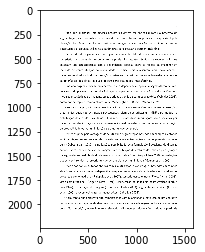

In [5]:
plt.imshow(img_mediana)
plt.show()

#cv2.imshow('MEDIANA', img_mediana)
#cv2.waitKey(0)

In [6]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_draw = img_gray

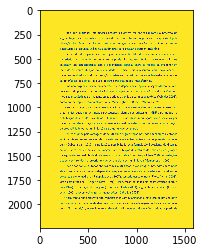

-1

In [7]:
plt.imshow(img_gray)
plt.show()

#cv2.imshow('BGR2GRAY', img_gray)
#cv2.waitKey(0)

OPERADOR MORFOLÓGICO: DILATAÇÃO

O nome da estrutura é img_erosion porque eu implementei utilizando o operador min() para selecionar o valor do pixel central do kernel, que na imagem invertida faria o processo de erosão.
A ideia de aplicar a dilatação nesse ponto é aproximar as letras dentro de uma palavra para serem agrupadas no histograma da projeção horizontal

In [8]:
kernel_size = 5
assert kernel_size % 2 != 0
num_linhas = img.shape[0]
num_colunas = img.shape[1]

img_erosion = np.copy(img_gray)
# calcula deslocamento
idx_del = int(np.floor(kernel_size / 2))
linhas_kernel = range(idx_del, (num_linhas - idx_del))

# exclui primeira e ultima linhas
for line in range(idx_del,(num_linhas-idx_del)):
    # exclui primeira e ultima colunas
    for col in range(idx_del,(num_colunas-idx_del)):
        # MIN ou MAX no caso de imagens binarias invertidas
        img_erosion[line, col] = np.min(
            img_gray[(line-idx_del):(line+idx_del),(col-idx_del):(col+idx_del)])

img = img_erosion

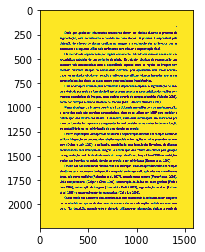

In [9]:
plt.imshow(img_erosion)
plt.show()

#cv2.imshow('DILATACAO', img_erosion)
#cv2.waitKey(0)

THRESHOLD

A utilização do limiar foi necessária para remover pixels com tons de cinza intermediários na imagem devido ao ruído

In [10]:
threshold_value = 127
max_value = 255
# exclui primeira e ultima linhas
img_threshold = np.copy(img)

for line in range(idx_del,(num_linhas-idx_del)):
    # exclui primeira e ultima colunas
    for col in range(idx_del, (num_colunas-idx_del)):
        if img[line, col] > threshold_value:
            img_threshold[line, col] = max_value
        else:
            img_threshold[line, col] = 0

img_gray = img_threshold

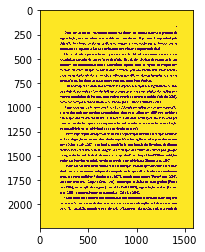

In [11]:
plt.imshow(img_threshold)
plt.show()

#cv2.imshow('LIMIARIZACAO', img_threshold)
#cv2.waitKey(0)

INVERTE ESCALA DE CINZA

Para que os 'bins' no histograma representem níveis de branco (linhas de palavras)

In [12]:
img_gray_inv = (255- img_gray)
dim = img_gray_inv.shape

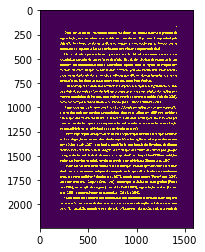

In [13]:
plt.imshow(img_gray_inv)
plt.show()

#cv2.imshow('INVERSAO ESCALA', img_gray_inv)
#cv2.waitKey(0)

IMPLEMENTACAO BLUR (MÉDIA)

Considerando que os valores são o número de linhas e colunas acima e ao lado do centro da operacao. O filtro da média foi utilizado para aproximar ainda mais as letras dentro de uma mesma palavra. o efeito 'borrão' permite que o histograma agrupe em 'bins' consecutivos as letras de uma mesma palavra 

In [14]:
x_kernel, y_kernel = (3,3)

dim_img = img.shape
num_linhas = dim_img[0]
num_colunas = dim_img[1]

img_blur = np.copy(img_gray_inv)

# deslocamento: x_kernel, y_kernel

# exclui primeira e ultima linhas
for line in range(x_kernel,num_linhas-x_kernel):
    # exclui primeira e ultima colunas
    for col in range(y_kernel,num_colunas-y_kernel):
        img_blur[line, col] = np.mean(
                img_gray_inv[line-x_kernel:line+x_kernel,col-y_kernel:col+y_kernel])

img_gray_inv = img_blur

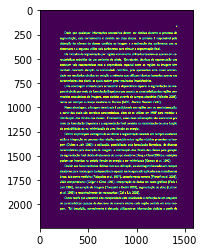

In [15]:
plt.imshow(img_gray_inv)
plt.show()

#cv2.imshow('FILTRO MEDIA', img_gray_inv)
#cv2.waitKey(0)

PROJEÇÃO VERTICAL

Identifica de linhas de palavras

In [16]:
vbins = np.zeros(dim[0]).reshape(dim[0],1)

for i in range(dim[0]):
    vbins[i] = sum(img_gray_inv[i,:])

PROJEÇÃO HORIZONTAL

Identifica as palavras dentro da linha

A variável todas_as_caixas armazenará as matrizes com as coordenadas dos retângulos ao redor de cada palavra destacada no formato:

|LeftUp     RightUp    |
|LeftBottom RightBottom|

In [17]:
todas_as_caixas = []  

vindex = 0
vstart = 0

while vindex < dim[0]:
    
    while vindex < len(vbins) and vbins[vindex] == 0: 
        vindex += 1
    
    if vindex == len(vbins):
        break
    
    vstart = vindex
    vend = vstart
    
    while vindex < len(vbins) and vbins[vindex]  > 0:
        vindex += 1
    
    vend = vindex - 1
    
    # projecao horizontal
    hbins = np.zeros(dim[1]).reshape(dim[1],1)
    for col in range(dim[1]):
        hbins[col] = sum(img_gray_inv[range(vstart, (vend + 1)),col])
    
    hindex = 0
    hstart = 0
    
    while hindex < dim[1]:
        
        while hindex < len(hbins) and hbins[hindex] == 0:
            hindex += 1
        
        if hindex == len(hbins):
            break
        
        hstart = hindex
        hend = hstart
        
        while hindex < len(hbins) and hbins[hindex] > 0:
            hindex += 1 
        
        hend = hindex - 1
 
        caixa = np.array([hstart, vstart, hend, vend]).reshape((2,2))
        todas_as_caixas.append(caixa)    
        cv2.rectangle(img_orig, (caixa[0,0], caixa[0,1]), 
                      (caixa[1,0], caixa[1,1]), (0,0,0), 2)


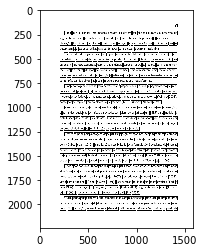

In [18]:
plt.imshow(img_orig)
plt.show()

#cv2.imshow('IMAGEM COM PALAVRAS IDENTIFICADAS', img_orig)
#cv2.waitKey(0)

ESCREVE EM ARQUIVO JPG A IMAGEM DE SAÍDA COM RETÂNGULO EM TORNO DAS PALAVRAS 

In [19]:
cv2.imwrite(path + img_out, img_orig)

True

ESCREVE ARQUIVO DE TEXTO COM COORDENADA SUPERIOR ESQUERDA, COMPRIMENTO E ALTURA DO RETÂNGULO

In [20]:
with open(path + arq_out,'w') as outfile:
    for coord in todas_as_caixas:
        # hend - hstart
        distx = coord[1,0] - coord[0,0]
        disty = coord[1,1] - coord[0,1]
        string = "%d %d %d %d\n" %(coord[0,0], coord[0,1], distx, disty)
        outfile.write(string) 